In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import numpy as np

In [192]:
#Reading in the logins json file and aggregating observations with 15 minute windows
logins = pd.read_json('logins.json')
logins['logins'] = logins.loc[:,'login_time'].apply(lambda x: 1)
logins = logins.set_index('login_time',drop=True).resample('15min').sum()
logins.logins = logins.logins.replace(np.nan,0)

# Part 1: Exploratory data analysis

### Rolling mean with fast and slow windows
Plotting ridership demand for each month after smoothing out all the noise to identify daily and weekly trends

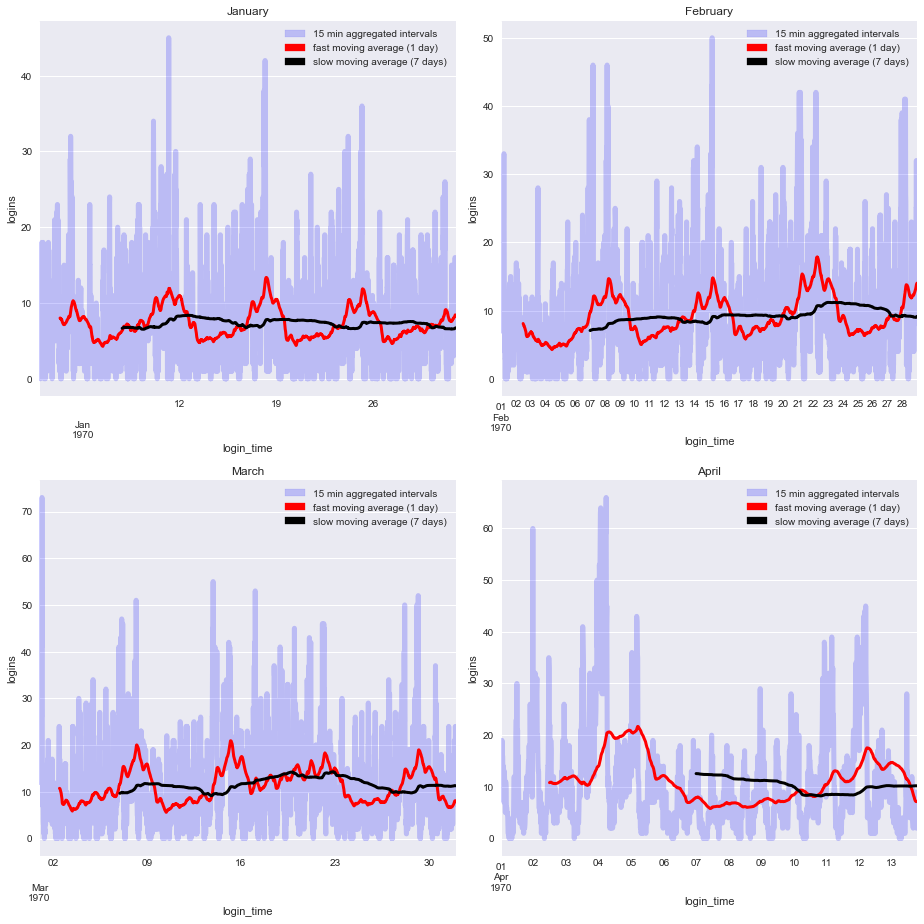

In [253]:
fig, ax = plt.subplots(figsize=(13,13))

plt.subplot(2,2,1)
logins.logins['1970-Jan-01':'1970-Jan-31'].plot(linewidth=5,color='blue',alpha=0.2)
logins.logins['1970-Jan-01':'1970-Jan-31'].rolling(window=144).mean().plot(linewidth=3,color='red')
logins.logins['1970-Jan-01':'1970-Jan-31'].rolling(window=576).mean().plot(linewidth=3,color='black')
blue_patch = mpatches.Patch(color='blue',label='15 min aggregated intervals',alpha=0.2)
red_patch = mpatches.Patch(color='red', label='fast moving average (1 day)')
black_patch = mpatches.Patch(color='black',label='slow moving average (7 days)')
plt.legend(handles=[blue_patch,red_patch,black_patch])
plt.ylabel('logins')
plt.title('January')

plt.subplot(2,2,2)
logins.logins['1970-Feb-01':'1970-Feb-28'].plot(linewidth=5,color='blue',alpha=0.2)
logins.logins['1970-Feb-01':'1970-Feb-28'].rolling(window=144).mean().plot(linewidth=3,color='red')
logins.logins['1970-Feb-01':'1970-Feb-28'].rolling(window=576).mean().plot(linewidth=3,color='black')
blue_patch = mpatches.Patch(color='blue',label='15 min aggregated intervals',alpha=0.2)
red_patch = mpatches.Patch(color='red', label='fast moving average (1 day)')
black_patch = mpatches.Patch(color='black',label='slow moving average (7 days)')
plt.legend(handles=[blue_patch,red_patch,black_patch])
plt.ylabel('logins')
plt.title('February')

plt.subplot(2,2,3)
logins.logins['1970-March-01':'1970-March-31'].plot(linewidth=5,color='blue',alpha=0.2)
logins.logins['1970-March-01':'1970-March-31'].rolling(window=144).mean().plot(linewidth=3,color='red')
logins.logins['1970-March-01':'1970-March-31'].rolling(window=576).mean().plot(linewidth=3,color='black')
blue_patch = mpatches.Patch(color='blue',label='15 min aggregated intervals',alpha=0.2)
red_patch = mpatches.Patch(color='red', label='fast moving average (1 day)')
black_patch = mpatches.Patch(color='black',label='slow moving average (7 days)')
plt.legend(handles=[blue_patch,red_patch,black_patch])
plt.ylabel('logins')
plt.title('March')

plt.subplot(2,2,4)
logins.logins['1970-April-01':].plot(linewidth=5,color='blue',alpha=0.2)
logins.logins['1970-April-01':].rolling(window=144).mean().plot(linewidth=3,color='red')
logins.logins['1970-April-01':].rolling(window=576).mean().plot(linewidth=3,color='black')
blue_patch = mpatches.Patch(color='blue',label='15 min aggregated intervals',alpha=0.2)
red_patch = mpatches.Patch(color='red', label='fast moving average (1 day)')
black_patch = mpatches.Patch(color='black',label='slow moving average (7 days)')
plt.legend(handles=[blue_patch,red_patch,black_patch])
plt.ylabel('logins')
plt.title('April')


plt.tight_layout()
plt.show()

#### Observation:
 - The daily ridership looks relatively steady with spikes at the end of each week during the weekends when there is a higher demand
 - The overall weekly demand for a each month looks quiet smooth and steady

### Closer look at average demand by hour during each day of the week

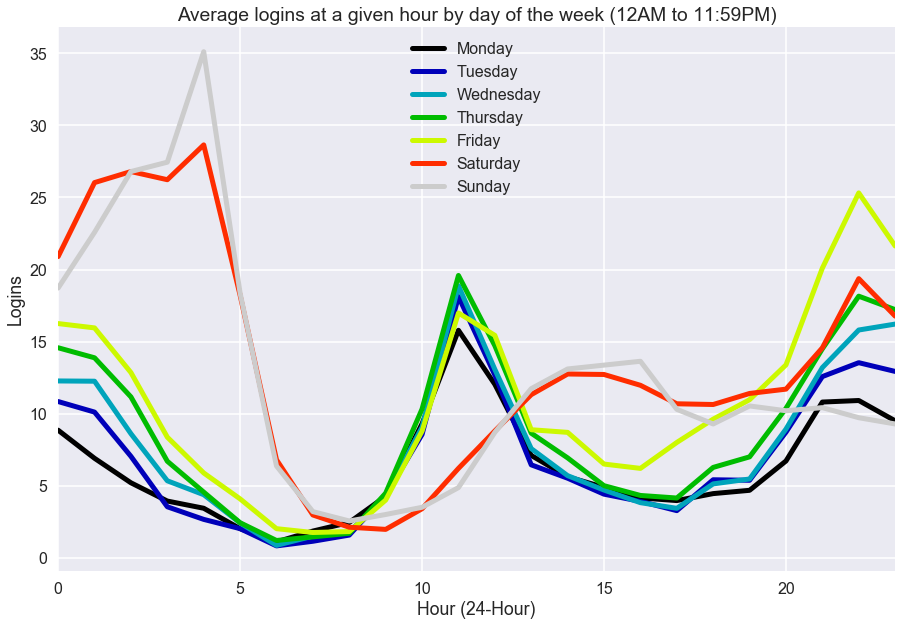

In [342]:
grouped = logins.groupby([logins.index.weekday,logins.index.hour]).mean()
grouped = grouped.unstack(level=0)
grouped.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.set('poster')
grouped.plot(figsize=(15,10),linewidth=5,colormap='nipy_spectral')
plt.xlabel('Hour (24-Hour)')
plt.ylabel('Logins')
plt.title('Average logins at a given hour by day of the week (12AM to 11:59PM)')
plt.show()

#### Observation
 - The average logins during Saturday and Sunday, spike sharply during early morning between 1am and 5am when the demand is higher than any other time of any other day and falls sharply between 8am and 10am. On Saturdays, demand slightly peaks again between 10pm and 11pm
 - On Fridays, the demand peaks twice, once between 10am and 12pm and then again between 11pm and 12am between which demand is relatively steady 
 - On all weekdays demand peaks between 11am and 12pm and falls in the later afternoon between 3pm and 4pm.
 - Overall there is relatively steady demand on all the days of the week in the afternoon between 12pm and 1pm. 

# Part 2: Experiment and metrics design <br> 
### A/B Testing 
The **metric of concern** for the A/B testing phase would be the **percentage increase in the number of trips made across** the toll, from Ultimate Gotham to Ultimate Metropolis or vice-versa after offering driver partners reimbursement for toll costs. This test will help ascertain if reimbursing the toll costs is a strong enough motivator for driver partners to move across cities and eliminate any other underlying reasons that might be keeping driver partners in just one city.
 - Offer half of the partner drivers reimbursements for toll costs if they make a trip across the city(Group A) and leave the other half to pay their own toll(Group B).
 - Over a period of two weeks, collect data on the amount of trips made across the city by both the groups.
 - Assuming Group A drivers made more trips across than the drivers of Group B, take mutliple permutation resamples to calculate the p-value of a group's trips across the toll being higher. If the p-value is extremely small (>0.05,academia standard), it will help us eliminate the possibility of the difference in trips made across by both groups being due to chance. 
 
If there is no significant increase in trips made across by Group A over Group B, or the p-value after permutation resampling is not significant, it could indicate other underlying reasons for partner drivers to stay in one city and simply offering reimbursements for toll might not be enough to achieve the objectives of the company. 

Since both the cities have a circadian rythm, offering peak hour rates during late evening and early morning to driver partners in addition to remibursing toll can be considered. Most big ride hailing services such as Lyft and Uber already do this. This could act as a stronger positive incentive to make trips across the cities when customers most need them to. In this case it would be crucial to perform a thorough cost-benefit analysis to ascertain such a policies effect on overall revenue, that is if the the revenue from the additional trips made across cities as a result of aformentioned policy is worth the extra cost to the customers and to the company. 

# Part 3: Predictive modelling

In [447]:
#Reading in the dataset and displaying overview
import json 
with open('ultimate_data_challenge.json') as j_data:
    data = json.load(j_data)
ultimate_data = pd.DataFrame(data)
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [448]:
ultimate_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### Data Munging

In [449]:
#Converting appropriate columns to have datetime objects 
from datetime import datetime
ud_df = ultimate_data 
def conv(s):
    return datetime.strptime(s,'%Y-%m-%d')
ud_df.loc[:,'last_trip_date'] = ud_df['last_trip_date'].apply(conv)
ud_df.signup_date = ud_df['signup_date'].apply(conv)

#### Feature Engineering 

In [450]:
# Building the taret variable column from the last_trip_date column and 
#extracting just the day from the trips_in_first_30_days column for it's feature column
def get_day(dt):
    return dt.day
def get_binary(dt):
    c = datetime.strptime('2014-06-01','%Y-%m-%d')
    if dt >= c:
        return 1
    else:
        return 0 
ud_df.last_trip_date = ud_df['last_trip_date'].apply(get_binary)
ud_df.signup_date = ud_df['signup_date'].apply(get_day)
#Converting boolean value in ultimate_black_user to binary
ud_df.ultimate_black_user = ud_df.ultimate_black_user.replace([True,False],[1,0])
#Renaming columns 'last_trip_date' and 'signup_date'
ud_df = ud_df.rename(columns = {'last_trip_date':'retained','signup_date':'signup_day'})

#### Handling Missing Values

In [460]:
#Filling missing values in the avg_rating_by_driver and avg_rating_of_driver columns by their respective means
ud_df.avg_rating_by_driver = ud_df.avg_rating_by_driver.fillna(ud_df.avg_rating_by_driver.mean())
ud_df.avg_rating_of_driver = ud_df.avg_rating_of_driver.fillna(ud_df.avg_rating_of_driver.mean())
#Filling missing values in the phone column with 'unknown'
ud_df.phone = ud_df.phone.fillna('Unknown')

#### One Hot Encoding all categorical variables

In [466]:
ud_df_encoded = pd.get_dummies(ud_df,drop_first=True)
ud_df_encoded.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,retained,signup_day,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone
0,3.67,5.0,4.7,1.10,1,25,15.4,4,1,46.2,1,0,0,1
1,8.26,5.0,5.0,1.00,0,29,0.0,0,0,50.0,0,0,0,0
2,0.77,5.0,4.3,1.00,0,6,0.0,3,0,100.0,0,0,0,1
3,2.36,4.9,4.6,1.14,1,10,20.0,9,1,80.0,1,0,0,1
4,3.13,4.9,4.4,1.19,0,27,11.8,14,0,82.4,0,1,0,0


#### Splitting the datatset into 80% test set and 20% hold out set and fitting models 

In [543]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
X = np.array(ud_df_encoded.drop(['retained'],axis=1))
y = np.array(ud_df_encoded['retained'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
from pandas_ml import ConfusionMatrix
%matplotlib inline
#ML helper function
def display_stats(model,name):
    print()
    print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print()
    print('Accuracy on unseen hold out set:',model.score(X_test,y_test)*100,'%')
    print()
    y_pred = model.predict(X_test)
    y_pred_s = pd.Series(y_pred).replace([0,1],['Churned','Retained'])
    y_test_s = pd.Series(y_test).replace([0,1],['Churned','Retained'])
    confusion_matrix = ConfusionMatrix(y_test_s,y_pred_s)
    confusion_matrix.plot(normalized=True,backend='seaborn')
    plt.title('Confusion Matrix For '+str(name))
    plt.show()
    print("Binary confusion matrix:\n%s" %confusion_matrix)
    print()
    print('Positive = Retained')
    print('Negative = Churned')
    print()
    print('True Positive Rate:',confusion_matrix.TPR * 100,'%')
    print('False Positive Rate:',confusion_matrix.FPR * 100,'%')
    print('True Negative Rate:',confusion_matrix.TNR * 100,'%')
    print('False Negative Rate:',confusion_matrix.FNR * 100,'%')

### Random Forest Classifier
The first model I fit on the data is a random forest classifier, which fits several weak decision trees on the data using bootsrap aggregating and averages out the predictions from all the decision trees to classify an observation
 - Random forest is a collinearity robust algorithim 
 - Works well on datasets with non-standardized features , with different ranges
 - Allows us to specify class_weights which greatly helps to give a balanced result in case of unbalanced classes like ours

In [524]:
#Tuning 'min_samples_leaf' and 'min_samples_split' using 5 fold cross validation
rf = RandomForestClassifier(n_estimators=20,n_jobs=-1,max_features='sqrt',random_state=42,class_weight={0:.4,1:.8})
param_grid1 = {"min_samples_split": np.arange(2, 11),
              "min_samples_leaf": np.arange(10, 21)}
rf_cv = GridSearchCV(rf,param_grid1,cv=5)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'min_samples_leaf': 15, 'min_samples_split': 2}
0.767775


In [525]:
#Tuning 'max_depth' using 5 fold cross validation 
rf = RandomForestClassifier(n_estimators=20,n_jobs=-1,max_features='sqrt',random_state=42,
                            min_samples_split=2,min_samples_leaf=15,class_weight = {0:.4,1:.8})
param_grid2 ={'max_depth':np.arange(21,31)}
rf_cv = GridSearchCV(rf,param_grid2,cv=5)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'max_depth': 23}
0.76795


#### Increasing the number of estimators, specifying class weights and fitting on hold out set

Training Accuracy: 80.37 %

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Accuracy on unseen hold out set: 76.95 %



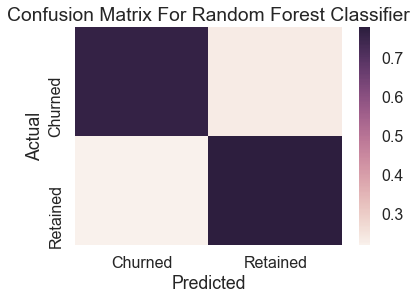

Binary confusion matrix:
Predicted  Churned  Retained  __all__
Actual                               
Churned       4751      1468     6219
Retained       837      2944     3781
__all__       5588      4412    10000

Positive = Retained
Negative = Churned

True Positive Rate: 77.8629992066 %
False Positive Rate: 23.6050812028 %
True Negative Rate: 76.3949187972 %
False Negative Rate: 22.1370007934 %


In [557]:
rf = RandomForestClassifier(n_estimators=400,n_jobs=-1,max_features='sqrt',random_state=42,
                            min_samples_split=2,min_samples_leaf=13,max_depth=22,class_weight={0:.4,1:.8})
rf.fit(X_train,y_train)
print('Training Accuracy:',rf.score(X_train,y_train)*100,'%')
display_stats(rf,'Random Forest Classifier')

#### Observation:
The model is not overfitted and generalized well in terms of handling the class imbalance, with almost identical success and error for both the classes, retention and churn. The model performed slightly better in identifying retention with true positive rate of 77.8% and false negative rate of 22.13% than predicting churn with a true negative rate of 76.3% and false positive rate of 23.6%  

### Stochastic Gradient Boosting 
Stochastic gradient boosting is another powerful ensemble algorithm that fits several weak decision trees using only a subsample of the dataset for each tree wherein each new tree attempts to correct the inaccuracies of the previous tree. 

In [527]:
#Tuning subsample
sgb = GradientBoostingClassifier(max_features='sqrt',random_state=42)
subsample_range = np.arange(1,8)/10
param_grid1 = dict(subsample=subsample_range)
sgb_cv = GridSearchCV(sgb,param_grid1,cv=5)
sgb_cv.fit(X_train,y_train)
print(sgb_cv.best_params_)
print(sgb_cv.best_score_)

{'subsample': 0.59999999999999998}
0.783775


In [531]:
#Tuning 'min_samples_leaf' and 'min_samples_split'
sgb = GradientBoostingClassifier(max_features='sqrt',random_state=42,subsample=0.6)
param_grid2 = {"min_samples_split": np.arange(2, 11),
              "min_samples_leaf": np.arange(1, 11)}
sgb_cv = GridSearchCV(sgb,param_grid2,cv=5,n_jobs=-1)
sgb_cv.fit(X_train,y_train)
print(sgb_cv.best_params_)
print(sgb_cv.best_score_)

{'min_samples_leaf': 3, 'min_samples_split': 7}
0.7844


In [535]:
#Tuning 'max_depth'
sgb = GradientBoostingClassifier(max_features='sqrt',random_state=42,subsample=0.6,min_samples_leaf=3,
                                 min_samples_split=7)
param_grid3 = {"max_depth":np.arange(1,11)}
sgb_cv = GridSearchCV(sgb,param_grid3,cv=5,n_jobs=-1)
sgb_cv.fit(X_train,y_train)
print(sgb_cv.best_params_)
print(sgb_cv.best_score_)

{'max_depth': 5}
0.788975


#### Increasing the number of estimators and fitting on hold out set

Training Accuracy: 85.9625 %

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Accuracy on unseen hold out set: 78.4 %



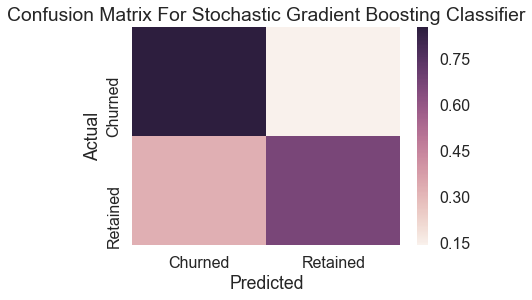

Binary confusion matrix:
Predicted  Churned  Retained  __all__
Actual                               
Churned       5310       909     6219
Retained      1251      2530     3781
__all__       6561      3439    10000

Positive = Retained
Negative = Churned

True Positive Rate: 66.9135149431 %
False Positive Rate: 14.6164978292 %
True Negative Rate: 85.3835021708 %
False Negative Rate: 33.0864850569 %


In [540]:
sgb = GradientBoostingClassifier(n_estimators=1000,max_features='sqrt',random_state=42,min_samples_leaf=3,
                                min_samples_split=7,max_depth=5,subsample=0.6,learning_rate=0.1)
sgb.fit(X_train,y_train)
print('Training Accuracy:',sgb.score(X_train,y_train)*100,'%')
display_stats(sgb,'Stochastic Gradient Boosting Classifier')

#### Observation:
Since stochastic gradient boosting does not support class weights, it did a much better job at predicting churn (the dominant class in the dataset) than the random forest classifier with a true negative rate of 85.3% and a low false positive rate of 14.6%, the tradeoffs being it has a high false negative rate and a lower true positive rate. 
If the metric of concern ultimate is most worried about is identifying customers who are at risk of churning than retention, this is a better model than the random forest classifier. 

### AdaBoost 
Adaboost is another boosting algorithim which fits several weak trees on the dataset and each individual tree attempts to correct the inaccuracies of the previous tree. 
However each decision tree in the adaboost model can be customized to handle class imbalances like the random forest classifier and unlike stochastic gradient boosting

#### Fitting Adaboost with a high number of estimators and low max_depth and learning rate and testing on hold out set

Training Accuracy: 78.35 %

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Accuracy on unseen hold out set: 76.73 %



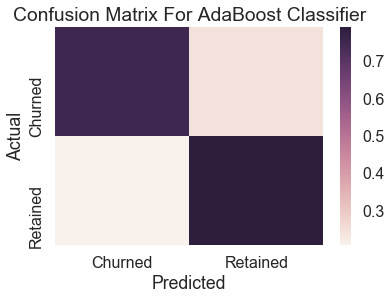

Binary confusion matrix:
Predicted  Churned  Retained  __all__
Actual                               
Churned       4682      1537     6219
Retained       790      2991     3781
__all__       5472      4528    10000

Positive = Retained
Negative = Churned

True Positive Rate: 79.1060565988 %
False Positive Rate: 24.7145843383 %
True Negative Rate: 75.2854156617 %
False Negative Rate: 20.8939434012 %


In [554]:
#Initializing each decision tree to be used for the boosting algorithm to handle clas imbalance 
#by specifying class_weights
tree = DecisionTreeClassifier(min_samples_leaf=3,min_samples_split=10,max_depth=4,class_weight = {0:.4,1:.8})
adaB = AdaBoostClassifier(base_estimator=tree,n_estimators=2000,learning_rate=0.01,random_state=42)
adaB.fit(X_train,y_train)
print('Training Accuracy:',adaB.score(X_train,y_train)*100,'%')
display_stats(adaB,'AdaBoost Classifier')

#### Observation:
The Adaboost also did a good job at handling class imbalances for our dataset. It has a higher score on predicitng the positive class, retention (the non-dominant clas in our dataset) than the random forest classifier with true positve rate of 79.1% and false negative rate of 20.8% and a slightly lower true negative rate of 75.2% and a higher false positive rate of 24.7%. 

### Feature Importances

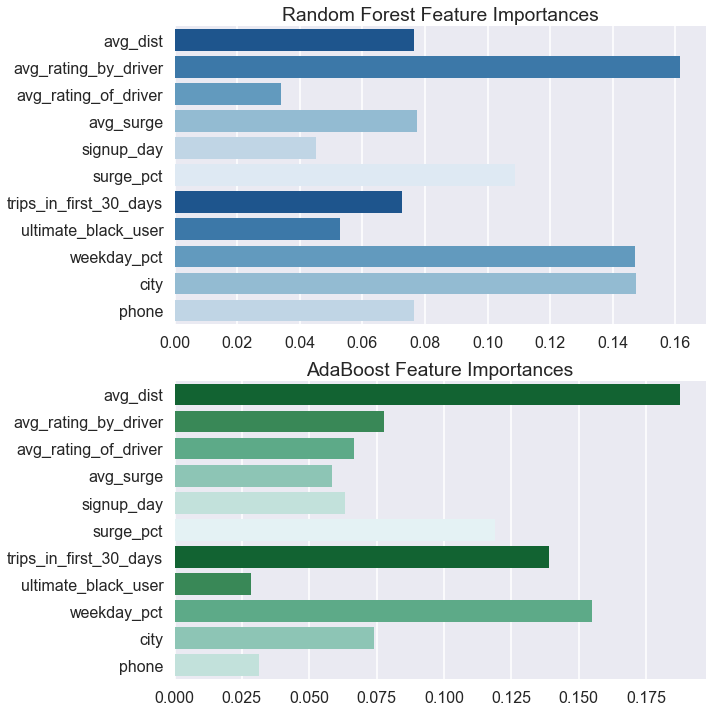

In [592]:
#Extracting assigned feature importances as assigned by the random forest classifier and adaboost classifier
def calc_fimps(m:'fitted model')->'numpy array':
    f_imp = np.append(m.feature_importances_[:9],sum(m.feature_importances_[9:11]))
    return np.append(f_imp,sum(m.feature_importances_[11:]))
rf_features = calc_fimps(rf)
adaB_features = calc_fimps(adaB)
features = np.array(['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','signup_day','surge_pct',
            'trips_in_first_30_days','ultimate_black_user','weekday_pct','city','phone'])
#Plotting on seaborn horizontal barplots
f, ax = plt.subplots(figsize=(10,10))
plt.subplot(2,1,1)
sns.barplot(x=rf_features,y=features,palette=sns.color_palette("Blues_r"))
plt.title('Random Forest Feature Importances')
plt.subplot(2,1,2)
sns.barplot(x=adaB_features,y=features,palette=sns.color_palette("BuGn_r"))
plt.title('AdaBoost Feature Importances')

plt.tight_layout()
plt.show()

The common features with high importance to determine customer retention identified by the random forest and adaboost are the percentage of trips taken during the weekday and the number of trips taken in the first 30 days after signing up. 
 - Offering customers certain amount of free rides or discounts for initial rides after they sign up is an important factor in insinuating customer loyalty and repeat customers.
 - Inititating a point system where customers build up points by taking trips during the weekday that translate into rewards such as discounts and free rides for loyal customers can also help with customer retention in the long run. 

<br>The random forest classifier and adaboost separately also idenitfied average rating by driver and average distance over all the trips taken, respectively as features with high importance for determining customer retention.